In [1]:
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from iexfinance.stocks import get_historical_intraday
from scipy.stats.mstats import gmean
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
plt.rcParams['figure.figsize'] = [10.0, 6.0]

In [2]:
#import sys
#!{sys.executable} -m pip install seaborn-qqplot
import scipy
scipy.__version__

'1.3.1'

# Initial params

In [8]:
rollingWindow = 20
ticker = 'FB'
start = datetime(2019, 1, 1)
end = datetime(2019, 12, 31)

# Loading intraday data

In [9]:
path = f'../data/intraday/{ticker}_intraday.{start.strftime("%Y-%m-%d")}_{end.strftime("%Y-%m-%d")}.pkl'
print(f'Target file path {path}')
if os.path.exists(path):
    print(f"Loaded intraday data from {path}")
    intraday = pd.read_pickle(path)
else:
    conf = input("Confirm loading from IEX? [Y,N] ")
    if conf.strip().upper()=='Y':
        os.environ['IEX_TOKEN'] = 'pk_70373470bd234060b26da8e689b8c47f' # insert your API key
        dfs = []

        for dt in pd.date_range(start, end, freq='B'):
            print(f"Loading intraday data for {dt}")
            df = get_historical_intraday(ticker, dt, output_format='pandas')
            if len(df)>0:
                df = df.loc[:,['date','marketOpen','marketClose','marketVolume']]
                df.rename(columns={'marketOpen':'open', 'marketClose':'close', 'marketVolume':'volume'}, inplace=True)
                dfs.append(df)

        intraday = pd.concat(dfs)
        intraday.index = pd.to_datetime(intraday.index)
        intraday.date = pd.to_datetime(intraday.date)
        print(f"Saved intraday data to {path}")
        intraday.to_pickle(path)
    else:
        print("Nothing to do")
        assert(False)
    
intraday.head()

Target file path ../data/intraday/FB_intraday.2019-01-01_2019-12-31.pkl
Loaded intraday data from ../data/intraday/FB_intraday.2019-01-01_2019-12-31.pkl


,date,open,close,volume
2019-04-01 09:30:00,2019-04-01,167.830,167.870,318566
2019-04-01 09:31:00,2019-04-01,167.935,168.250,68135
2019-04-01 09:32:00,2019-04-01,168.270,168.270,126594
2019-04-01 09:33:00,2019-04-01,168.265,168.035,48753
2019-04-01 09:34:00,2019-04-01,168.030,168.140,71750


Prepare daily aggregate and geometric moving average

In [10]:
daily = intraday.groupby('date').agg({'open': 'first', 'close': 'last', 'volume': 'sum'})
daily.index = pd.to_datetime(daily.index)
daily['gmav'] = daily.volume.rolling(rollingWindow).agg(gmean).transform(np.ceil)
daily.tail()

,open,close,volume,gmav
date,,,,
2019-12-24,206.300,205.15,3228990,8304072.0
2019-12-26,205.566,207.79,5780968,8288985.0
2019-12-27,208.670,208.10,6958411,8154020.0
2019-12-30,207.860,204.41,7428730,8258235.0
2019-12-31,203.995,205.09,5792282,8124318.0


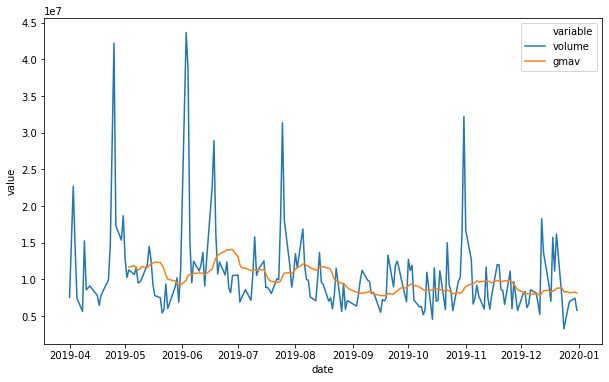

In [11]:
sns.lineplot(x='date', y='value', hue='variable', data=daily.loc[:,['volume','gmav']].reset_index().melt(id_vars=['date']))
plt.show()

# Fit lognorm dist
For some reason scipy fails to accurately fit lognorm to volume, so fitting norm to log volume

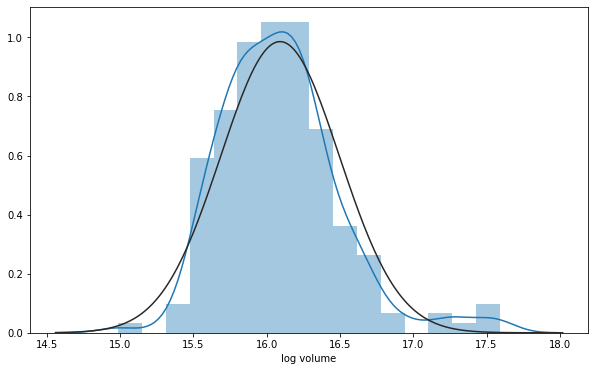

In [12]:
sns.distplot(np.log(daily.volume), fit=stats.norm, axlabel='log volume')
plt.show()

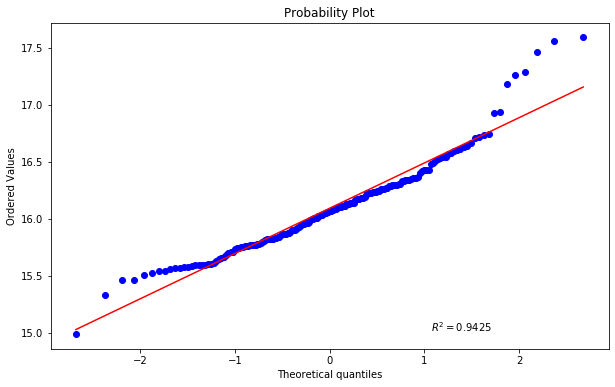

In [13]:
_ = stats.probplot(np.log(daily.volume), dist=stats.norm,  plot=plt, rvalue=True)

# Fitting invgamma

/Users/Andrey/anaconda3/envs/FinEng/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


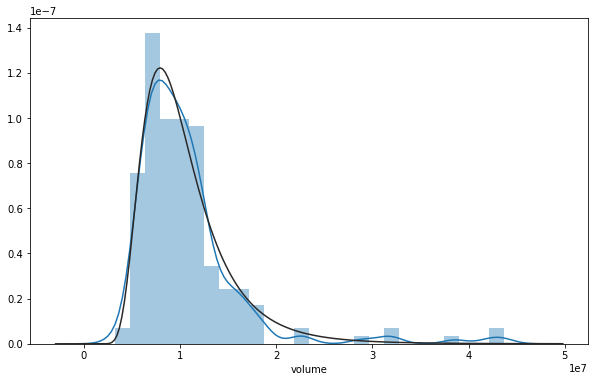

In [14]:
sns.distplot(daily.volume, fit=stats.invgamma)
plt.show()

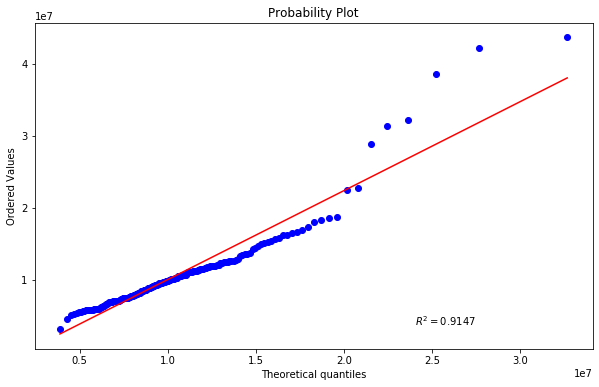

In [15]:
_ = stats.probplot(daily.volume, dist=stats.invgamma, sparams=stats.invgamma.fit(daily.volume), plot=plt, rvalue=True)

# Fitting gamma

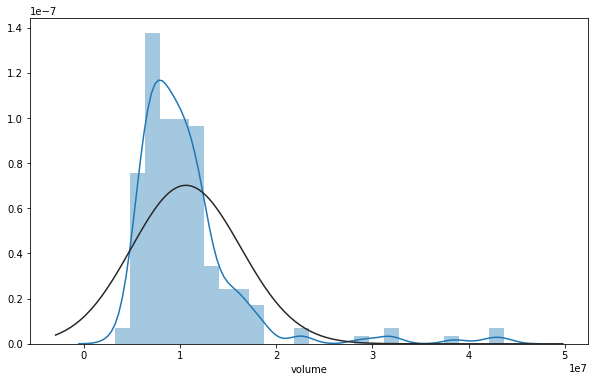

In [16]:
sns.distplot(daily.volume, fit=stats.gamma)
plt.show()

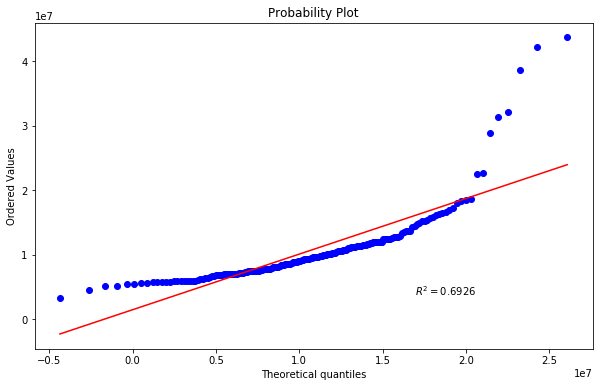

In [17]:
_ = stats.probplot(daily.volume, dist=stats.gamma, sparams=stats.gamma.fit(daily.volume), plot=plt, rvalue=True)

# ARMA for initial daily volume prediction

In [18]:
daily["lv"] = np.log(daily.gmav)
daily["mu_lv"] = daily.lv.rolling(rollingWindow).mean()
daily["sigma_lv"] = daily.lv.rolling(rollingWindow).std()
daily["excess_lv"] = daily.lv - daily.mu_lv
daily.tail()

,open,close,volume,gmav,lv,mu_lv,sigma_lv,excess_lv
date,,,,,,,,
2019-12-24,206.300,205.15,3228990,8304072.0,15.932257,15.941458,0.053641,-0.009201
2019-12-26,205.566,207.79,5780968,8288985.0,15.930438,15.934175,0.043288,-0.003737
2019-12-27,208.670,208.10,6958411,8154020.0,15.914022,15.927403,0.033872,-0.013381
2019-12-30,207.860,204.41,7428730,8258235.0,15.926721,15.925566,0.032793,0.001156
2019-12-31,203.995,205.09,5792282,8124318.0,15.910372,15.924741,0.032965,-0.014369


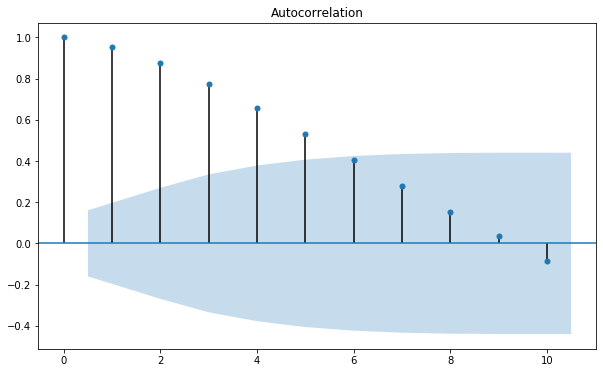

In [19]:
plot_acf(daily.excess_lv.dropna(), lags=10)
plt.show()

In [25]:
model = ARIMA(daily.excess_lv.dropna(), order=(3,0,1))
model_fit = model.fit(trend='nc')
print(model_fit.summary())

/Users/Andrey/anaconda3/envs/FinEng/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:              excess_lv   No. Observations:                  149
Model:                     ARMA(3, 1)   Log Likelihood                 353.387
Method:                       css-mle   S.D. of innovations              0.022
Date:                Sun, 17 May 2020   AIC                           -696.773
Time:                        11:15:32   BIC                           -681.754
Sample:                             0   HQIC                          -690.671
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
ar.L1.excess_lv     2.3305      0.113     20.552      0.000       2.108       2.553
ar.L2.excess_lv    -1.7515      0.209     -8.363      0.000      -2.162      -1.341
ar.L3.excess_lv     0.4054      

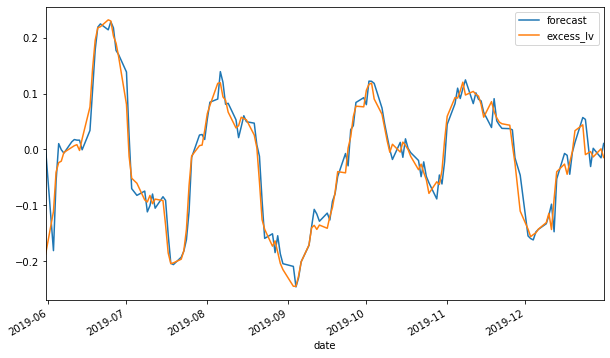

In [26]:
model_fit.plot_predict()
plt.show()

# Intraday volume curve

In [182]:
intraday['raw_vc'] = intraday.loc[:,['date','volume']].groupby('date').apply(lambda x: x / float(x.sum()))
intraday['time'] = intraday.index.time
intraday.tail()

,date,open,close,volume,raw_vc,time
2019-12-31 15:55:00,2019-12-31,205.050,205.32,80138,0.013835,15:55:00
2019-12-31 15:56:00,2019-12-31,205.340,205.13,52535,0.009070,15:56:00
2019-12-31 15:57:00,2019-12-31,205.140,205.16,76489,0.013205,15:57:00
2019-12-31 15:58:00,2019-12-31,205.155,205.15,98079,0.016933,15:58:00
2019-12-31 15:59:00,2019-12-31,205.160,205.09,187882,0.032437,15:59:00


In [28]:
VC = intraday.loc[:,['time','raw_vc']].groupby('time').mean() # average over many days
VC

,raw_vc
time,
09:30:00,0.033069
09:31:00,0.008181
09:32:00,0.007495
09:33:00,0.007200
09:34:00,0.006704
...,...
15:55:00,0.009343
15:56:00,0.006315
15:57:00,0.007135


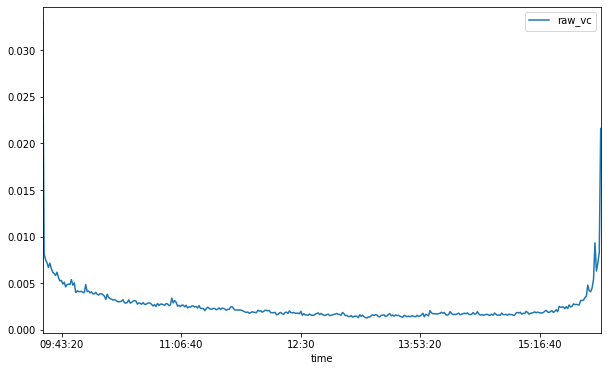

In [29]:
VC.plot()
plt.show()

## Very spiky VC - need to apply smother

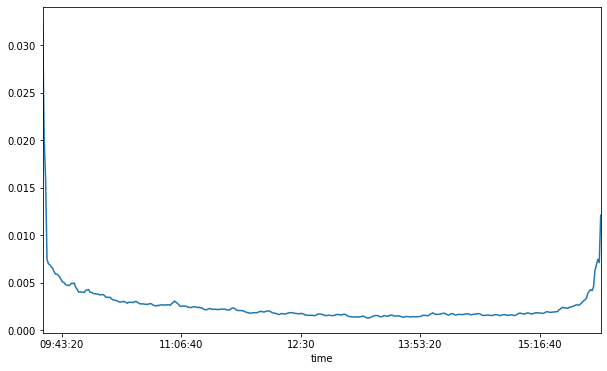

In [50]:
# rolling mean
VC['vc'] = VC.raw_vc.rolling(3, min_periods=1).mean()
VC.vc = VC.vc/VC.vc.sum() # normalize to 1
VC['cumVC'] = VC.vc.cumsum()
VC.vc.plot()
plt.show()

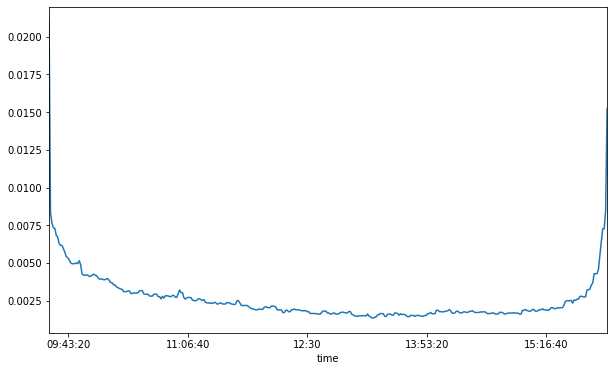

In [31]:
VC['vc'] = VC.raw_vc.rolling(window=3, min_periods=1, center=True).median()
VC.vc = VC.vc/VC.vc.sum() # normalize to 1
VC['cumVC'] = VC.vc.cumsum()
VC.vc.plot()
plt.show()

# Prediction

In [34]:
realized = intraday.where(intraday.date==intraday.date.max()).dropna().reset_index().loc[:,['time','volume']].set_index('time')
realized["cumVolume"] = realized.volume.cumsum()
finalVolume = realized.cumVolume[-1]
realized

,volume,cumVolume
time,,
09:30:00,144900.0,144900.0
09:31:00,27349.0,172249.0
09:32:00,55596.0,227845.0
09:33:00,27339.0,255184.0
09:34:00,39788.0,294972.0
...,...,...
15:55:00,80138.0,5377297.0
15:56:00,52535.0,5429832.0
15:57:00,76489.0,5506321.0


In [35]:
predictedLogExcess = model_fit.predict().array[-1]
predictedDailyLV = daily.mu_lv.array[-2] + predictedLogExcess # previous day rolling mean + excess
predictedDailyLV

15.936221992156275

In [36]:
DailyLVvar = daily.lv.rolling(rollingWindow).var()[-2]
DailyLVvar

0.001075363653706093

In [37]:
k0 = 0.5 * rollingWindow

In [51]:
prediction = realized.join(VC)
prediction['x'] = np.log(prediction.volume/prediction.vc)
prediction['n'] = np.arange(1,len(prediction)+1)
prediction['xbar'] = prediction.x.expanding().mean()
prediction['sigma_x'] = prediction.x.expanding().std()
prediction['mu'] = (predictedDailyLV*k0+prediction.n*prediction.xbar)/(k0+prediction.n) # apply 'unknown mean and variance' prediction
prediction['predictedVolume'] = np.ceil(np.exp(prediction.mu))
prediction

,volume,cumVolume,raw_vc,vc,cumVC,x,n,xbar,sigma_x,mu,predictedVolume
time,,,,,,,,,,,
09:30:00,144900.0,144900.0,0.033069,0.032487,0.032487,15.310703,1,15.310703,NaN,15.879357,7876204.0
09:31:00,27349.0,172249.0,0.008181,0.020262,0.052750,14.115425,2,14.713064,0.845189,15.732362,6799519.0
09:32:00,55596.0,227845.0,0.007495,0.015963,0.068712,15.063369,3,14.829832,0.630933,15.680901,6458460.0
09:33:00,27339.0,255184.0,0.007200,0.007491,0.076204,15.110087,4,14.899896,0.533873,15.640129,6200428.0
09:34:00,39788.0,294972.0,0.006704,0.007008,0.083211,15.552083,5,15.030333,0.546658,15.634259,6164140.0
...,...,...,...,...,...,...,...,...,...,...,...
15:55:00,80138.0,5377297.0,0.009343,0.006309,0.966374,16.357295,386,15.365899,0.578092,15.380301,4781672.0
15:56:00,52535.0,5429832.0,0.006315,0.006906,0.973280,15.844602,387,15.367136,0.577855,15.381470,4787268.0
15:57:00,76489.0,5506321.0,0.007135,0.007464,0.980744,16.142542,388,15.369134,0.578449,15.383383,4796431.0


In [52]:
# apply 'unknown mean, known variance' prediction
prediction.loc[prediction.n>100, 'mu'] = (prediction.n*prediction.xbar/np.power(prediction.sigma_x,2) + \
    predictedDailyLV/DailyLVvar)/(prediction.n/np.power(prediction.sigma_x,2) + 2/DailyLVvar)
prediction

,volume,cumVolume,raw_vc,vc,cumVC,x,n,xbar,sigma_x,mu,predictedVolume
time,,,,,,,,,,,
09:30:00,144900.0,144900.0,0.033069,0.032487,0.032487,15.310703,1,15.310703,NaN,15.879357,7876204.0
09:31:00,27349.0,172249.0,0.008181,0.020262,0.052750,14.115425,2,14.713064,0.845189,15.732362,6799519.0
09:32:00,55596.0,227845.0,0.007495,0.015963,0.068712,15.063369,3,14.829832,0.630933,15.680901,6458460.0
09:33:00,27339.0,255184.0,0.007200,0.007491,0.076204,15.110087,4,14.899896,0.533873,15.640129,6200428.0
09:34:00,39788.0,294972.0,0.006704,0.007008,0.083211,15.552083,5,15.030333,0.546658,15.634259,6164140.0
...,...,...,...,...,...,...,...,...,...,...,...
15:55:00,80138.0,5377297.0,0.009343,0.006309,0.966374,16.357295,386,15.365899,0.578092,10.802291,4781672.0
15:56:00,52535.0,5429832.0,0.006315,0.006906,0.973280,15.844602,387,15.367136,0.577855,10.808724,4787268.0
15:57:00,76489.0,5506321.0,0.007135,0.007464,0.980744,16.142542,388,15.369134,0.578449,10.810412,4796431.0


[]

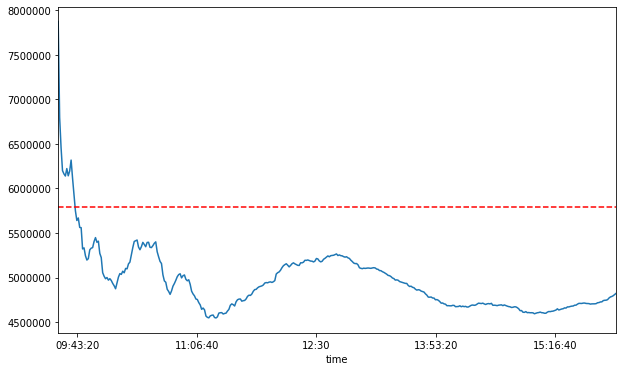

In [53]:
prediction.predictedVolume.plot()
plt.axhline(y=finalVolume, c='red', ls='--')
plt.plot()

In [54]:
PERF = prediction.loc[:,['predictedVolume']]
PERF['elpv'] = np.log(PERF.predictedVolume)-np.log(finalVolume)
PERF['SE'] = np.power(PERF.predictedVolume - finalVolume, 2)
PERF['w'] = PERF.elpv.apply(lambda x: 2 if x>0 else 1)
PERF['LE'] = PERF.w*PERF.elpv*PERF.elpv.abs()
PERF

,predictedVolume,elpv,SE,w,LE
time,,,,,
09:30:00,7876204.0,0.307320,4.342731e+12,2,0.188891
09:31:00,6799519.0,0.160326,1.014526e+12,2,0.051409
09:32:00,6458460.0,0.108865,4.437931e+11,2,0.023703
09:33:00,6200428.0,0.068092,1.665832e+11,2,0.009273
09:34:00,6164140.0,0.062222,1.382784e+11,2,0.007743
...,...,...,...,...,...
15:55:00,4781672.0,-0.191736,1.021333e+12,1,-0.036763
15:56:00,4787268.0,-0.190566,1.010053e+12,1,-0.036316
15:57:00,4796431.0,-0.188654,9.917192e+11,1,-0.035590


In [55]:
# RMSE
np.sqrt(PERF.SE.sum()/len(PERF))

910083.1357836167

In [56]:
# ALE
PERF.LE.sum()

-11.034005048069329

# Comparison with naive gmean

In [57]:
# RMSE
np.abs(finalVolume - daily.gmav[-2])

2465953.0

In [58]:
# ALE
d = np.log(daily.gmav[-2]) - np.log(finalVolume)
w = 2 if d>0 else 1
w*d*np.abs(d)

0.25160224947485504

# PROVAL :(

In [59]:
np.exp(predictedDailyLV)

8337066.652609941

In [60]:
finalVolume

5792282.0

In [61]:
daily.gmav[-2]

8258235.0

In [62]:
prediction.predictedVolume[-1]

4823202.0

# Forecasting performance

For each date:
- IG 
 - obtain trailing 21-day avg volume for each minute
 - obtain trailing 21-day var volume for each minute
 - obtain daily volume for previous 21 day, compute avg and var
 - compute {$\alpha_t$}
 - obtain the current day's realized volume for each minute
 - for each minute compute forecasted daily volume and forecast error
 - calculate RMSE for the date
 
- LN 
 - obtain daily volume for previous 21 day, compute avg and var
 - train ARMA, predict initial daily volume
 - for each minute compute avg percentage of daily volume, smooth and normalize
 - obtain the current day's realized volume for each minute
 - for each minute compute forecasted daily volume and forecast error
 - calculate RMSE for the date

In [ ]:
intraday.date.unique()
get_daily_volume(intraday.iloc[0:21*390,:])

In [138]:
def get_vc(minutelyVolume, ndays=21):
    """
    Parameters: 
    minutelyVolume (DataFrame): minutely volume indexed by datetime, expected columns: date, volume
    ndays (int): window width in days
  
    Returns: 
    DataFrame: smoothed volume curve (percentage of daily volume) indexed by time
    """
    assert minutelyVolume.date.nunique() == ndays, f"Number of days should be {ndays}, got {minutelyVolume.date.nunique()}"
    minutelyVolume = minutelyVolume.loc[:,['date', 'volume']].copy()
    minutelyVolume['raw_vc'] = minutelyVolume.loc[:,['date','volume']].groupby('date').apply(lambda x: x / float(x.sum()))
    minutelyVolume['time'] = minutelyVolume.index.time
    
    VC = minutelyVolume.loc[:,['time','raw_vc']].groupby('time').mean() # average over days
    VC['vc'] = VC.raw_vc.rolling(window=3, min_periods=1).mean() # use rolling avg to smooth
    VC.vc = VC.vc/VC.vc.sum() # normalize to 1
    return VC[['vc']]

In [139]:
def get_daily_volume(minutelyVolume, ndays=21):
    """
    Parameters: 
    minutelyVolume (DataFrame): minutely volume indexed by datetime, expected columns: date, volume
    ndays (int): window width in days
  
    Returns: 
    DataFrame: daily volume indexed by date
    """
    assert minutelyVolume.date.nunique() == ndays, f"Number of days should be {ndays}, got {minutelyVolume.date.nunique()}"
    daily = minutelyVolume.groupby('date').agg({'volume': 'sum'}).copy()
    daily.index = pd.to_datetime(daily.index)
    
    return daily

In [140]:
def get_initial_vorecast(dailyVolume, ndays=21, fn=np.mean):
    assert len(dailyVolume)==ndays, f"Number of days should be {ndays}, got {len(dailyVolume)}"
    return dailyVolume.agg(fn).transform(np.ceil).values[0]

In [167]:
def ALE(forecast, realized):
    """
    Parameters: 
    forecast (Series): prediction of total daily for every minute
    realized (float): realized total daily volume
  
    Returns: 
    DataFrame: daily volume indexed by date
    """
    d = forecast - realized
    w_fn = lambda x: 1 if x<0 else 2
    return np.sum(np.abs(d) * d.apply(w_fn))

In [172]:
dates = np.flip(intraday.date.unique())
k0 = 0.2 * rollingWindow

for i,dt in enumerate(dates[:-rollingWindow-1]):
    df_validate = intraday[intraday.date == dt]
    realized_volume = df_validate.volume.sum()
    realized_log_volume = np.log(realized_volume)
    
    train_start_dt, train_end_dt = dates[[i+rollingWindow+1, i+1]]
    df_train = intraday[intraday.date.between(train_start_dt, train_end_dt)]
    
    vc = get_vc(df_train)
    nMinutes = len(vc)
    
    daily = get_daily_volume(df_train)
    daily_log_volume_var = daily.volume.var()
    
    initial_volume_forecast = get_initial_vorecast(daily)
    initial_log_volume_forecast = np.log(initial_volume_forecast)    
    
    realized = df_validate.reset_index().loc[:,['time','volume']].set_index('time')
    realized = realized.join(vc)
    realized['x'] = np.log(realized.volume/realized.vc)
    realized['n'] = np.arange(1,len(realized)+1)
    realized['xbar'] = realized.x.expanding().mean()
    realized['mu'] = (initial_log_volume_forecast*k0+realized.n*realized.xbar)/(k0+realized.n) 
    realized['predictedVolume'] = np.ceil(np.exp(realized.mu))
    
    realized['mu2'] = realized['mu']
    realized['sigma_x'] = realized.x.expanding().std()    
    realized.loc[realized.n>100, 'mu2'] = (realized.n*realized.xbar/np.power(realized.sigma_x,2) + \
        initial_log_volume_forecast/daily_log_volume_var)/(realized.n/np.power(realized.sigma_x,2) + 2/daily_log_volume_var)
    realized['predictedVolume2'] = np.ceil(np.exp(realized.mu2))
    
    print(ALE(np.log(realized.predictedVolume), realized_log_volume))
    print(ALE(np.log(realized.predictedVolume2), realized_log_volume))
    print(ALE(pd.Series(np.repeat(initial_log_volume_forecast, nMinutes)), realized_log_volume))
    break
    

72.08263493232143
75.36509740329728
329.3193318659596


In [194]:
df = pd.DataFrame(columns=['volume', 'vc', 'n'], index=pd.date_range("09:30", "15:59", freq="1min").time)
df.loc[pd.to_datetime('09:30:00').time(), ['volume', 'vc']] = (1 ,2)
df

,volume,vc,n
09:30:00,1,2,NaN
09:31:00,NaN,NaN,NaN
09:32:00,NaN,NaN,NaN
09:33:00,NaN,NaN,NaN
09:34:00,NaN,NaN,NaN
...,...,...,...
15:55:00,NaN,NaN,NaN
15:56:00,NaN,NaN,NaN
15:57:00,NaN,NaN,NaN
15:58:00,NaN,NaN,NaN
